<a href="https://colab.research.google.com/github/andoanminhkhanh/trituenhantao/blob/main/AI_c%E1%BB%A7a_CNN_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Khai báo thư viện**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from keras.applications import ResNet50
from tensorflow.keras.layers import Flatten,Dense,Dropout
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

##**Tiền xử lý dữ liệu**

In [3]:
from imutils import paths
imgTrain = list(paths.list_images("/content/drive/MyDrive/AI/DATA/train"))
imgTest = list(paths.list_images("/content/drive/MyDrive/AI/DATA/val"))

In [4]:
X_train = []
y_train = []

In [5]:
for path_train in imgTrain:

	Y_train = path_train.split(os.path.sep)[-2]

	# Xu ly anh
	img = cv2.imread(path_train)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	img = cv2.resize(img, (150, 150))

	# Them vao du lieu data va label
	X_train.append(img)
	y_train.append(Y_train)

In [6]:
from sklearn.preprocessing import LabelBinarizer

X_train = np.array(X_train)
y_train = np.array(y_train)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
X_train = X_train.astype('float32') / 255

**TEST**

In [7]:
X_test = []
y_test = []

In [8]:
for path_test in imgTest:

	Y_test = path_test.split(os.path.sep)[-2]

	# Xu ly anh
	img1 = cv2.imread(path_test)
	img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
	img1 = cv2.resize(img1, (150, 150))

	# Them vao du lieu data va label
	X_test.append(img1)
	y_test.append(Y_test)

In [9]:
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = lb.fit_transform(y_test)
X_test = X_test.astype('float32') / 255

##**XÂY DỰNG MÔ HÌNH**

In [10]:
import tensorflow as tf

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), # Lớp tích chập 2D, 32 bộ lọc kích thước 3 x 3, hàm kích hoạt là ReLU
                                                                                          # kích thước ảnh đầu vào 150x150 với 3 kênh màu
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D kích thước 2x2 dùng để giảm kích thước và số lượng đặc trưng thông qua lấy giá trị lớn nhất trong mỗi vùng pool.
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), # Lớp tích chập với 32 filter kích thước 3x3 và 32 bộ lọc
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D
    tf.keras.layers.Flatten(), # chuyển đổi đầu ra từ tensor nhiều chiều thành một vector 1D.
    tf.keras.layers.Dense(128, activation = tf.nn.relu), # Lớp kết nối đầy đủ với 128 đơn vị và hàm kích hoạt là ReLU
    tf.keras.layers.Dense(2, activation = tf.nn.softmax) # phân loại đối tượng vào 2 lớp khác nhau, hàm softmax để tạo phân phối xác suất trên các lớp
])

In [12]:
model.compile(optimizer = 'adam', # phương pháp tối ưu hóa Adam
                     loss = 'sparse_categorical_crossentropy', # hàm mất mát đo sự khác biệt giữa đầu ra dự đoán và nhãn thực tế;
                     # sparse categorical cross-entropy thích hợp khi nhãn đầu vào không được mã hóa theo one-hot encoding, mà là các giá trị số nguyên
                     metrics = ['accuracy']) # các độ đo để đánh giá hiệu suất của mô hình. Độ chính xác ('accuracy') là tỷ lệ giữa số dự đoán đúng và tổng số mẫu

In [13]:
# Kiến trúc mô hình
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [14]:
# Huấn luyện mô hình
epochs3 = 15
history3 = model.fit(
  X_train, y_train,
  validation_data = (X_test, y_test),
  epochs = epochs3,
  batch_size = 32)

Epoch 1/15
80/80 [==============================] - 87s 1s/step - loss: 0.4203 - accuracy: 0.8426 - val_loss: 0.1632 - val_accuracy: 0.9396
Epoch 2/15
80/80 [==============================] - 78s 966ms/step - loss: 0.1643 - accuracy: 0.9351 - val_loss: 0.1900 - val_accuracy: 0.9249
Epoch 3/15
80/80 [==============================] - 74s 926ms/step - loss: 0.1305 - accuracy: 0.9516 - val_loss: 0.1762 - val_accuracy: 0.9304
Epoch 4/15
80/80 [==============================] - 73s 919ms/step - loss: 0.1135 - accuracy: 0.9528 - val_loss: 0.1795 - val_accuracy: 0.9286
Epoch 5/15
80/80 [==============================] - 72s 898ms/step - loss: 0.0968 - accuracy: 0.9610 - val_loss: 0.1491 - val_accuracy: 0.9505
Epoch 6/15
80/80 [==============================] - 77s 967ms/step - loss: 0.0647 - accuracy: 0.9772 - val_loss: 0.1443 - val_accuracy: 0.9524
Epoch 7/15
80/80 [==============================] - 72s 898ms/step - loss: 0.0366 - accuracy: 0.9898 - val_loss: 0.1792 - val_accuracy: 0.9469
Ep

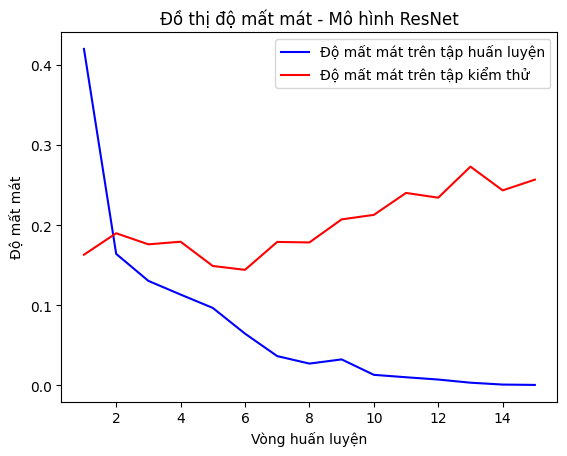

In [15]:
# Đồ thị hàm mất mát
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs = range(1, len(loss3)+1)
plt.plot(epochs, loss3, 'b', label = 'Độ mất mát trên tập huấn luyện')
plt.plot(epochs, val_loss3, 'r', label = 'Độ mất mát trên tập kiểm thử')
plt.title('Đồ thị độ mất mát - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ mất mát')
plt.legend()
plt.show()

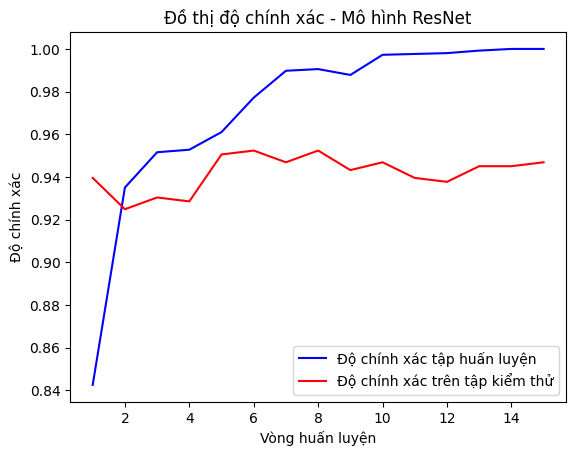

In [16]:
# Đồ thị độ chính xác của mô hình
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
plt.plot(epochs, acc3, 'b', label = 'Độ chính xác tập huấn luyện')
plt.plot(epochs, val_acc3, 'r', label = 'Độ chính xác trên tập kiểm thử')
plt.title('Đồ thị độ chính xác - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ chính xác')
plt.legend()
plt.show()

**ẢNH XÁM**

In [17]:
X_train_gray = []
y_train_gray = []

In [18]:
for path_train in imgTrain:

	Y_train_gray = path_train.split(os.path.sep)[-2]

	# Xu ly anh
	img_gray = cv2.imread(path_train)
	img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
	img_gray = cv2.resize(img_gray, (150, 150))

	# Them vao du lieu data va label
	X_train_gray.append(img_gray)
	y_train_gray.append(Y_train_gray)

In [19]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

X_train_gray = np.array(X_train_gray)
y_train_gray = np.array(y_train_gray)

y_train_gray = lb.fit_transform(y_train_gray)
X_train_gray = X_train_gray.astype('float32') / 255

In [20]:
X_test_gray = []
y_test_gray = []

In [21]:
for path_test in imgTest:

	Y_test_gray = path_test.split(os.path.sep)[-2]

	# Xu ly anh
	img1_gray = cv2.imread(path_test)
	img1_gray = cv2.cvtColor(img1_gray, cv2.COLOR_BGR2GRAY)
	img1_gray = cv2.resize(img1_gray, (150, 150))

	# Them vao du lieu data va label
	X_test_gray.append(img1_gray)
	y_test_gray.append(Y_test_gray)

In [22]:
X_test_gray = np.array(X_test_gray)
y_test_gray = np.array(y_test_gray)
y_test_gray = lb.fit_transform(y_test_gray)
X_test_gray = X_test_gray.astype('float32') / 255

In [23]:
import tensorflow as tf

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 1)), # Lớp tích chập 2D, 32 bộ lọc kích thước 3 x 3, hàm kích hoạt là ReLU
                                                                                          # kích thước ảnh đầu vào 150x150 với 3 kênh màu
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D kích thước 2x2 dùng để giảm kích thước và số lượng đặc trưng thông qua lấy giá trị lớn nhất trong mỗi vùng pool.
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'), # Lớp tích chập với 32 filter kích thước 3x3 và 32 bộ lọc
    tf.keras.layers.MaxPooling2D(2,2), # Lớp MaxPooling 2D
    tf.keras.layers.Flatten(), # chuyển đổi đầu ra từ tensor nhiều chiều thành một vector 1D.
    tf.keras.layers.Dense(128, activation = tf.nn.relu), # Lớp kết nối đầy đủ với 128 đơn vị và hàm kích hoạt là ReLU
    tf.keras.layers.Dense(2, activation = tf.nn.softmax) # phân loại đối tượng vào 2 lớp khác nhau, hàm softmax để tạo phân phối xác suất trên các lớp
])

In [25]:
model.compile(optimizer = 'adam', # phương pháp tối ưu hóa Adam
                     loss = 'sparse_categorical_crossentropy', # hàm mất mát đo sự khác biệt giữa đầu ra dự đoán và nhãn thực tế;
                     # sparse categorical cross-entropy thích hợp khi nhãn đầu vào không được mã hóa theo one-hot encoding, mà là các giá trị số nguyên
                     metrics = ['accuracy']) # các độ đo để đánh giá hiệu suất của mô hình. Độ chính xác ('accuracy') là tỷ lệ giữa số dự đoán đúng và tổng số mẫu

In [26]:
# Huấn luyện mô hình
epochs3 = 15
history3 = model.fit(
  X_train_gray, y_train_gray,
  validation_data = (X_test_gray, y_test_gray),
  epochs = epochs3,
  batch_size = 32)

Epoch 1/15
80/80 [==============================] - 84s 1s/step - loss: 0.3660 - accuracy: 0.8489 - val_loss: 0.1625 - val_accuracy: 0.9414
Epoch 2/15
80/80 [==============================] - 68s 853ms/step - loss: 0.1758 - accuracy: 0.9315 - val_loss: 0.1551 - val_accuracy: 0.9487
Epoch 3/15
80/80 [==============================] - 68s 858ms/step - loss: 0.1457 - accuracy: 0.9481 - val_loss: 0.1349 - val_accuracy: 0.9432
Epoch 4/15
80/80 [==============================] - 70s 872ms/step - loss: 0.1177 - accuracy: 0.9559 - val_loss: 0.1221 - val_accuracy: 0.9597
Epoch 5/15
80/80 [==============================] - 70s 879ms/step - loss: 0.1024 - accuracy: 0.9610 - val_loss: 0.1822 - val_accuracy: 0.9194
Epoch 6/15
80/80 [==============================] - 69s 854ms/step - loss: 0.0843 - accuracy: 0.9673 - val_loss: 0.1513 - val_accuracy: 0.9542
Epoch 7/15
80/80 [==============================] - 67s 840ms/step - loss: 0.0616 - accuracy: 0.9756 - val_loss: 0.1499 - val_accuracy: 0.9469
Ep

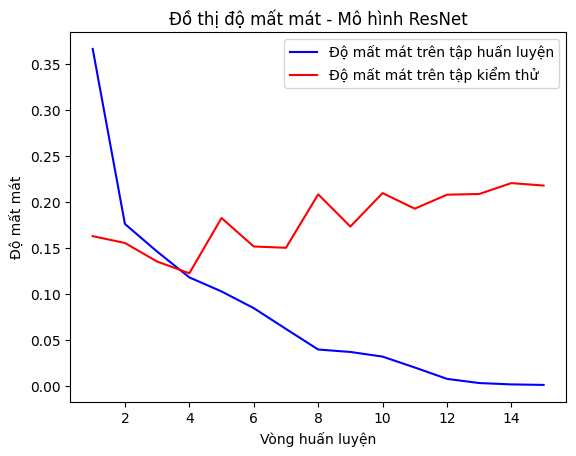

In [27]:
# Đồ thị hàm mất mát
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs = range(1, len(loss3)+1)
plt.plot(epochs, loss3, 'b', label = 'Độ mất mát trên tập huấn luyện')
plt.plot(epochs, val_loss3, 'r'
, label = 'Độ mất mát trên tập kiểm thử')
plt.title('Đồ thị độ mất mát - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ mất mát')
plt.legend()
plt.show()

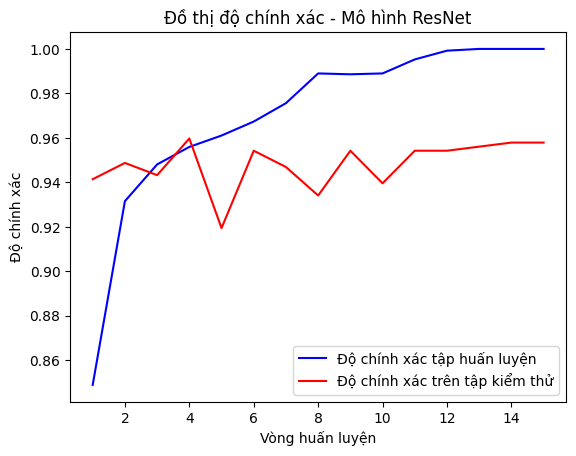

In [28]:
# Đồ thị độ chính xác của mô hình
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
plt.plot(epochs, acc3, 'b', label = 'Độ chính xác tập huấn luyện')
plt.plot(epochs, val_acc3, 'r', label = 'Độ chính xác trên tập kiểm thử')
plt.title('Đồ thị độ chính xác - Mô hình ResNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ chính xác')
plt.legend()
plt.show()

In [29]:
model.save('/content/drive/MyDrive/AI/CNN_GRAY.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
